In [1]:
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from clustering_class import bag_of_words

Using TensorFlow backend.


In [2]:
cleaned_dat = pd.read_csv("data/clean_desc_data.csv")
companylist = cleaned_dat["ticker"]
short = cleaned_dat[cleaned_dat["intro"].str.len() <= 512]
big = cleaned_dat[cleaned_dat["intro"].str.len() > 512]
short_intro = short["intro"].values.tolist()
big_first = pd.concat([big["ticker"], big["intro"].str[:512]], axis=1)
big_second = pd.concat([big["ticker"], big["intro"].str[512:1024]], axis=1)
big_second = big_second[big_second.iloc[:, 1].str.len() > 100]
short_intro = short["intro"].values.tolist()
big_first_intro = big_first["intro"].values.tolist()
big_second_intro = big_second["intro"].values.tolist()

big_bert1 = pd.read_csv("bert_vec_output/first_long_CLS_long_bert.csv").iloc[:, 1:]
big_bert2 = pd.read_csv("bert_vec_output/second_long_CLS_long_bert.csv").iloc[:, 1:]
short_bert = pd.read_csv("bert_vec_output/short_CLS_long_bert.csv").iloc[:, 1:]
all_data = []
filte = []
for i in big_first["ticker"]:
    filte.append(True) if i in big_second["ticker"].values else filte.append(False)
for i in range(6):
    big_bert1_i = big_bert1.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    big_bert2_i = big_bert2.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    short_bert_i = short_bert.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    big_bert2_i.index = big_bert1_i[filte].index
    big_bert1_i[filte] = (big_bert1_i[filte] + big_bert2_i) / 2
    big.index = big_bert1_i.index
    short.index = short_bert_i.index
    big_bert1_i.insert(loc=0, column="company", value=big["ticker"])
    short_bert_i.insert(loc=0, column="company", value=short["ticker"])
    all_data.append(pd.concat([short_bert_i, big_bert1_i], axis=0, ignore_index=True))

In [3]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [4]:
f = open("data/baidu_stopwords.txt", "r")
stopwords = f.read().splitlines()
f.close()
disc = cleaned_dat["intro"]
bag_of_words = bag_of_words(companylist, disc)
bag_of_words.transform(stopwords=stopwords)
bag_matrix = bag_of_words.get_vector()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.539 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [6]:
print(all_data[0].shape)
print(bag_matrix.shape)

(3924, 1025)
(3924, 35773)


## Tuning layer dim hyperparameters so that the performance of SAE is guarenteed

In [5]:
input_X=all_data[5].iloc[:,1:]
#input_X=bag_matrix.iloc[:,1:]
n_epochs   = 100
batch_size = 128
dims = [input_X.shape[-1], 500, 500, 2000, 50] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size

In [8]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(input_X, input_X, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7942e-05
Epoch 2/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7902e-05
Epoch 3/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7861e-05
Epoch 4/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7821e-05
Epoch 5/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7784e-05
Epoch 6/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7748e-05
Epoch 7/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7714e-05
Epoch 8/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7681e-05
Epoch 9/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7649e-05
Epoch 10/100
3924/3924 [==============================] - 14s 3ms/step - loss: 2.7619e-05
Epoch 11/100
3924/3924 [==============================] - 14s 4ms/step - loss: 2.7589e-05
Epoch 12/100
3924/3

In [10]:
#BERT matrix
Y_pred=autoencoder.predict(input_X)
triu_elements_pred=[a for a in np.nditer(np.triu(cosine_similarity(input_X,Y_pred),1)) if a>0]
triu_elements_ori=[a for a in np.nditer(np.triu(cosine_similarity(input_X),1)) if a>0]
print('Average similarity after SAE processing: ' + str(round(np.mean(triu_elements_pred),4)))
print('Std similarity after SAE processing: ' + str(round(np.std(triu_elements_pred),6)))
print('Original average similarity: '+ str(round(np.mean(triu_elements_ori),4)))
print('Original std similarity: '+ str(round(np.std(triu_elements_ori),4)))

Average similarity after SAE processing: 0.205
Std similarity after SAE processing: 0.056402
Original average similarity: 0.0424
Original std similarity: 0.0318


In [ ]:
#Bag of words matrix
Y_pred=autoencoder.predict(input_X)
triu_elements_pred=[a for a in np.nditer(np.triu(cosine_similarity(input_X,Y_pred),1)) if a>0]
triu_elements_ori=[a for a in np.nditer(np.triu(cosine_similarity(input_X),1)) if a>0]
print('Average similarity after SAE processing: ' + str(round(np.mean(triu_elements_pred),4)))
print('Std similarity after SAE processing: ' + str(round(np.std(triu_elements_pred),6)))
print('Original average similarity: '+ str(round(np.mean(triu_elements_ori),4)))
print('Original std similarity: '+ str(round(np.std(triu_elements_ori),4)))

In [9]:
# save the SAE weight
autoencoder.save_weights('DEC_model_output/bow_sae_model_weights.h5')

## Define the DAE clustering layer

In [7]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [6]:
loss = 0
index = 0
maxiter = 1000
n_clusters = 26
update_interval = 100
index_array = np.arange(input_X.shape[0])
tol = 0.001 # tolerance threshold to stop training

In [7]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')


In [8]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights('DEC_model_output/sae_model_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

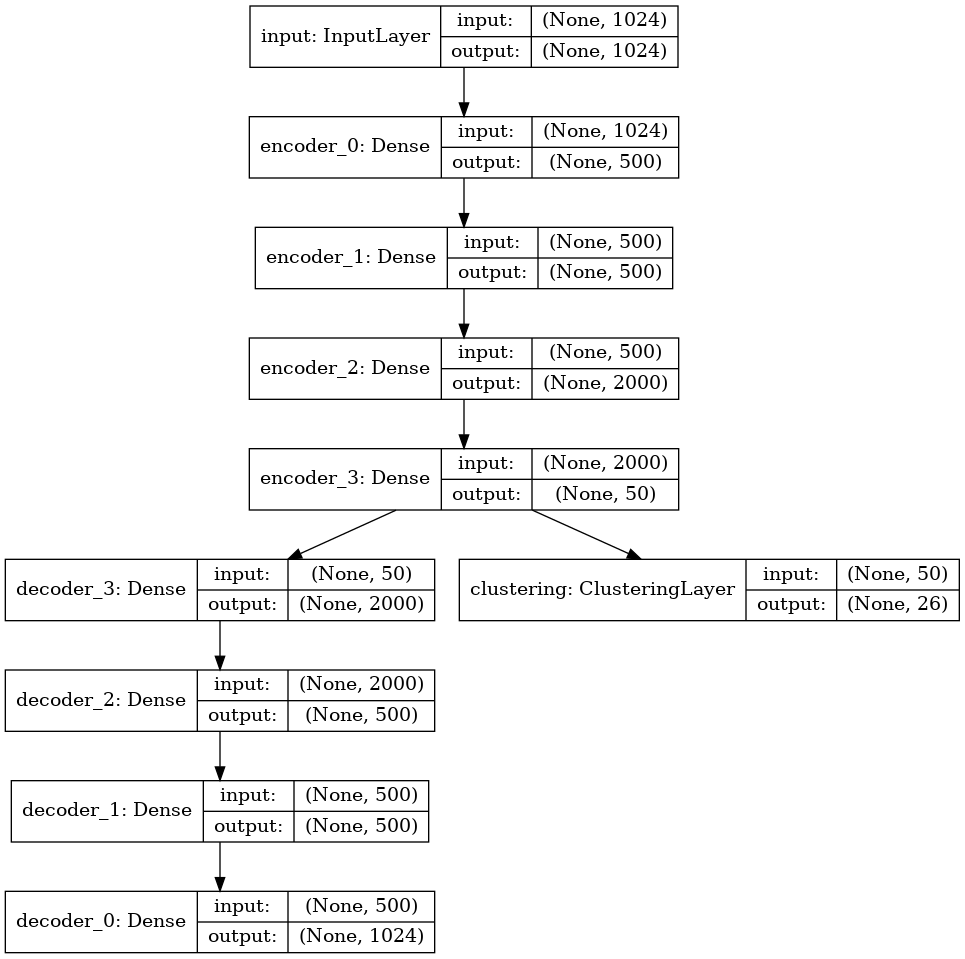

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='DEC_model_output/encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='DEC_model_output/encoder.png')

### Initialize the clustering weights to kmeans results

In [28]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
y_pred = kmeans.fit_predict(encoder.predict(input_X))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_kmean=np.copy(y_pred)
y_pred_last = np.copy(y_pred)

In [29]:
kmean_cluster_df=pd.DataFrame({'company':companylist,'kmean_cluster':y_pred_kmean})
kmean_cluster_df.groupby('kmean_cluster').count()

,company
kmean_cluster,
0,154
1,153
2,168
3,161
4,202
5,121
6,179
7,168
8,153


In [30]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(input_X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, input_X.shape[0])]
    loss = model.train_on_batch(x=input_X.iloc[idx], y=[p[idx], input_X.iloc[idx]])
    index = index + 1 if (index + 1) * batch_size <= input_X.shape[0] else 0

In [ ]:
# get the prediction 
q, _ = model.predict(input_X, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

## Clustering result

In [1]:
# DEC cluster result
DEC_cluster_df=pd.DataFrame({'company':companylist,'DEC_cluster':y_pred})
DEC_cluster_df.groupby('DEC_cluster').count()

NameError: name 'pd' is not defined

In [ ]:
model.save_weights('DEC_model_output/bow_DEC_model_final.h5')
DEC_cluster_df.to_csv('data/bow_DEC_cluster.csv')

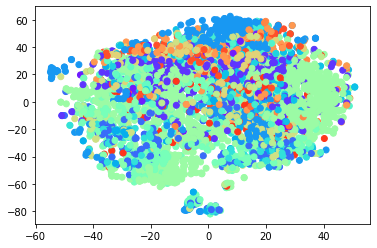

In [139]:
# DEC cluster
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2).fit_transform(input_X)
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
colors = cm.rainbow((y_pred-np.min(y_pred))/np.max(y_pred))
plt.scatter(vis_x, vis_y, c=colors)
plt.clim(-0.5, 9.5)
plt.show()

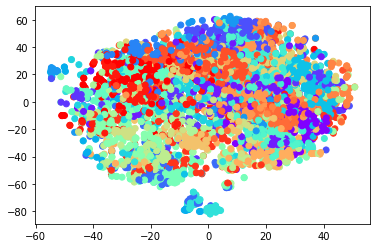

In [140]:
# k-mean cluster
colors = cm.rainbow((y_pred_kmean-np.min(y_pred_kmean))/np.max(y_pred_kmean))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap("jet", 256))
plt.clim(-0.5, 9.5)
plt.show()